In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from tqdm import tqdm

In [2]:
df = pd.read_csv("./data/K-Data.csv")

/var/folders/78/9j91h4q516z7774553xzp19m0000gn/T/ipykernel_42168/2728384747.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./data/K-Data.csv")


In [3]:
df.head()

,m,s,e,u,grat_orientation,grat_contrast,grat_spat_freq,grat_phase,response,smoothed_response,region,unit_type,response_type,invariance,fit_quality,c_inv_ts
0,Ntsr1Cre_2019_0002,3,11,14,0,0.0,0.010000,0,0.013316,0.010386,LGN,NaN,rising,invariant,good,2021-05-21 14:28:55
1,Ntsr1Cre_2019_0002,3,11,14,0,0.0,0.010000,90,0.013333,0.013067,LGN,NaN,rising,invariant,good,2021-05-21 14:28:55
2,Ntsr1Cre_2019_0002,3,11,14,0,0.0,0.010000,180,0.009592,0.009712,LGN,NaN,rising,invariant,good,2021-05-21 14:28:55
3,Ntsr1Cre_2019_0002,3,11,14,0,0.0,0.010000,270,0.007634,0.007415,LGN,NaN,rising,invariant,good,2021-05-21 14:28:55
4,Ntsr1Cre_2019_0002,3,11,14,0,0.0,0.024022,0,0.003597,0.003837,LGN,NaN,rising,invariant,good,2021-05-21 14:28:55


In [47]:
v1 = df.query("region == 'V1'")
m = v1.m.unique()[2]
v1 = v1[v1.m == m] # take for all mice later
v1 = v1.copy()  # to prevent warning
v1["mouse_unit"] = v1["m"] + "_" + v1["u"].astype(str)
v1 = v1.groupby(["mouse_unit", "grat_orientation", "grat_contrast", "grat_spat_freq", "grat_phase"]).sum().reset_index()
v1 = v1[["mouse_unit", "grat_orientation", "grat_contrast", "grat_spat_freq", "grat_phase", "response"]]

orientations = sorted(v1.grat_orientation.unique())  # sort is in ascending
contrasts = sorted(v1.grat_contrast.unique())
spatial_frequencies = sorted(v1.grat_spat_freq.unique())
phases = sorted(v1.grat_phase.unique())
units = sorted(v1.mouse_unit.unique())

tuncurv = np.empty((len(units), len(orientations), len(contrasts), len(spatial_frequencies), len(phases))).tolist()
print(len(orientations) * len(contrasts) * len(spatial_frequencies) * len(phases) * len(units))


# MOST INEFFICIENT CODE EVER
for i, u in tqdm(enumerate(units)):
    for j, o in enumerate(orientations):
        for k, c in enumerate(contrasts):
            for l, s in enumerate(spatial_frequencies):
                for m, p in enumerate(phases):
                    res = v1.query(f"mouse_unit == '{u}'").query(
                        f"grat_orientation == {o}").query(
                        f"grat_contrast == {c}").query(
                        f"grat_spat_freq == {s}").query(
                        f"grat_phase == {p}")["response"].to_list()
                    if len(res) == 0:
                        tuncurv[i][j][k][l][m] = 0
                        print("not found", u, o, c, s, p)
                    else:
                        tuncurv[i][j][k][l][m] = res[0]

# print(res)

/var/folders/78/9j91h4q516z7774553xzp19m0000gn/T/ipykernel_42168/76583901.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  v1 = v1.groupby(["mouse_unit", "grat_orientation", "grat_contrast", "grat_spat_freq", "grat_phase"]).sum().reset_index()


186624


26it [03:48,  8.90s/it]

In [7]:
# Therefore different units can be recorded from different experiement but in the same session we should be able to assume that
# the the neuron index is just u - Will need to check

print(df.query("region == 'V1'").query("u == 32").e.unique())
print(df.query("region == 'V1'").query("u == 32").s.unique())
print(df.query("region == 'V1'").query("u == 32").unit_type.unique())

[2 5]
[4]
['excit']


In [4]:
v1 = df.query("region == 'V1'")
m = v1.m.unique()[2]
v1_data = v1[v1.m == m] # take for all mice later
# v1_data = v1_data.query("grat_spat_freq == 0.332966").query("grat_phase == [180]")
v1_data = v1_data[['u', 'unit_type', 'grat_orientation', 'grat_contrast', 'response', 'smoothed_response']].reset_index(drop=True)

In [5]:
data = v1[v1.m == m]
orientations = data.grat_orientation.unique()
contrasts = data.grat_contrast.unique()
spatial_frequencies = data.grat_spat_freq.unique()
phases = data.grat_phase.unique()
units = sorted(data.u.unique())

In [6]:
spatial_frequencies

array([0.01     , 0.0240215, 0.0577032, 0.138612 , 0.332966 , 0.799834 ])

In [7]:
phases

array([  0,  90, 180, 270])

In [8]:
# v1_data.query("unit_type != 'excit'").head()
#  'grat_spat_freq', 'grat_phase'
v1_data = v1_data[['u', 'unit_type', 'grat_orientation', 'grat_contrast', 'response', 'smoothed_response']].reset_index(drop=True)
v1_data = v1_data.groupby(['unit_type','u', 'grat_contrast', 'grat_orientation'], as_index=False).mean() # call it a different name

In [9]:
len(v1_data)

8160

In [10]:
v1_data.head()

,unit_type,u,grat_contrast,grat_orientation,response,smoothed_response
0,excit,2,0.0,0,0.000763,0.000828
1,excit,2,0.0,15,0.000995,0.000984
2,excit,2,0.0,30,0.001027,0.001104
3,excit,2,0.0,45,0.000988,0.000923
4,excit,2,0.0,60,0.000696,0.000765


In [11]:
v1_data.to_csv('./data/v1_data.csv', index=False)

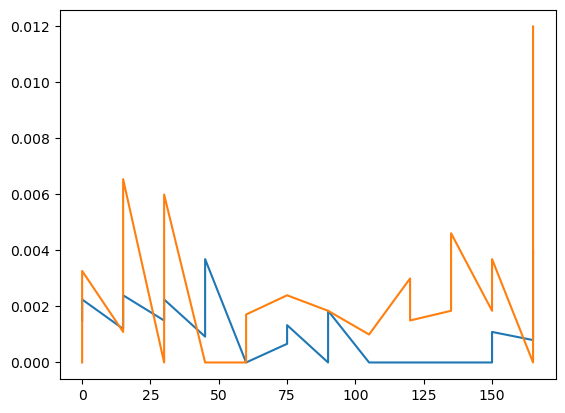

In [12]:
v1_data_max = v1[v1.m == m]
v1_data_max = v1_data_max[['u', 'unit_type', 'grat_orientation', 'grat_contrast', 'grat_spat_freq', 'grat_phase', 'response', 'smoothed_response']].reset_index(drop=True)

# Find max grat_spat_freq and grat_phase at max contrast
max_contrast = v1_data_max.query("grat_contrast == 1")[["u", "grat_spat_freq", "grat_phase", "response", "smoothed_response"]]
max_contrast = max_contrast.sort_values(by='response', ascending=False)
df_max_grat_freq_phase = max_contrast.groupby('u').first().reset_index()[["u", "grat_spat_freq", "grat_phase"]]
df_max_grat_freq_phase.head()


v1_data_max = pd.merge(df_max_grat_freq_phase, v1_data_max, on=["u", "grat_spat_freq", "grat_phase"], how="left")
v1_data_max = v1_data_max.sort_values(by=['grat_contrast', 'grat_orientation'], ascending=True)

con1 = "0.464386"
con2 = "1"
neuron = "2"

test_orientations = v1_data_max.query(f"u == {neuron}").query(f"grat_contrast == {con1}").grat_orientation.to_list()
test_responses = v1_data_max.query(f"u == {neuron}").query(f"grat_contrast == {con1}").response.to_list()
plt.plot(test_orientations, test_responses)

test_orientations = v1_data_max.query(f"u == {neuron}").query(f"grat_contrast == {con2}").grat_orientation.to_list()
test_responses = v1_data_max.query(f"u == {neuron}").query(f"grat_contrast == {con2}").response.to_list()
plt.plot(test_orientations, test_responses)

plt.show()

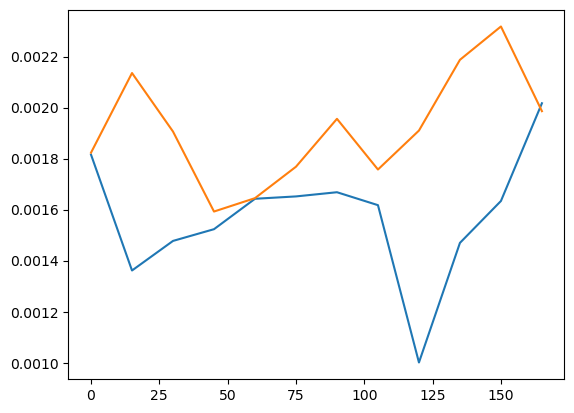

In [13]:
con1 = "0.464386"
con2 = "1"
neuron = "2"

test_orientations = v1_data.query(f"u == {neuron}").query(f"grat_contrast == {con1}").grat_orientation.to_list()
test_responses = v1_data.query(f"u == {neuron}").query(f"grat_contrast == {con1}").response.to_list()
plt.plot(test_orientations, test_responses)

test_orientations = v1_data.query(f"u == {neuron}").query(f"grat_contrast == {con2}").grat_orientation.to_list()
test_responses = v1_data.query(f"u == {neuron}").query(f"grat_contrast == {con2}").response.to_list()
plt.plot(test_orientations, test_responses)

plt.show()

In [14]:
contrasts

array([0.       , 0.0432773, 0.103411 , 0.186966 , 0.303066 , 0.464386 ,
       0.68854  , 1.       ])

In [15]:
v1_data.u.unique()

array([ 2,  4,  6,  9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
       24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 42, 43,
       44, 45, 46, 47, 49, 50, 51, 52, 54, 55, 56, 57, 59, 60, 62, 63, 64,
       65, 66, 67, 68, 69, 70, 73, 74, 77, 78, 80, 81, 82, 83, 84, 86, 87,
       89, 90, 91, 92,  5,  7,  8, 10, 58, 71, 72, 79])

In [16]:
# n_u = len(units)
# n_spat = len(spatial_frequencies)
# tuning_curves = np.zeros([n_u * n_spat, len(contrasts), len(orientations)])


In [17]:
# for i, tc in enumerate(tuning_curves):
#     plt.imshow(tc)
#     plt.show()

In [18]:
# v1_data

# Assuming df is your DataFrame
# Replace df with the actual name of your DataFrame

# Get unique values for each column
unique_u = v1_data['u'].unique()
unique_contrast = v1_data['grat_contrast'].unique()
unique_orientation = v1_data['grat_orientation'].unique()

# Create a 3D numpy array filled with NaN values
shape = (len(unique_u), len(unique_contrast), len(unique_orientation))
result_array = np.full(shape, np.nan)

# Iterate through the DataFrame and fill the array
for index, row in v1_data.iterrows():
    u_index = np.where(unique_u == row['u'])[0][0]
    contrast_index = np.where(unique_contrast == row['grat_contrast'])[0][0]
    orientation_index = np.where(unique_orientation == row['grat_orientation'])[0][0]
    
    result_array[u_index, contrast_index, orientation_index] = row['response']

# Now result_array contains the 3D array you're looking for


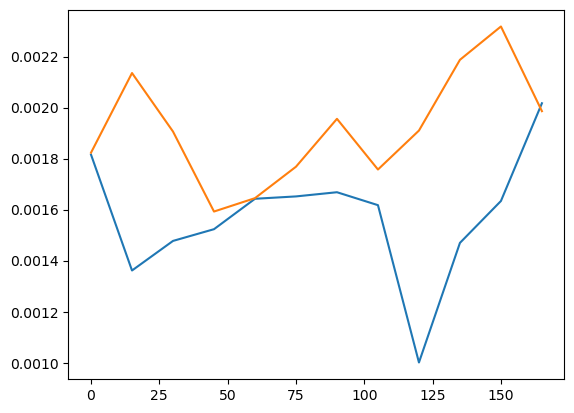

In [19]:
# plt.plot(unique_orientation, result_array[0][0])
# plt.plot(unique_orientation, result_array[0][1])
# plt.plot(unique_orientation, result_array[0][2])
# plt.plot(unique_orientation, result_array[0][3])
# plt.plot(unique_orientation, result_array[0][4])
plt.plot(unique_orientation, result_array[0][5])
plt.plot(unique_orientation, result_array[0][7])
# plt.plot(unique_orientation, result_array[0][6])
plt.show()

In [20]:
import mouse_utils as mu

In [21]:
from scipy.ndimage.filters import gaussian_filter1d

/var/folders/78/9j91h4q516z7774553xzp19m0000gn/T/ipykernel_40040/1567020577.py:1: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [22]:
# J_array = [0.69, 0.64, 0., -0.29]
# P_array = [-2.21, -2.21, -0.8, -0.8]
# w_array = [3.46, 3.46, 3.46, 3.46]

# J_array = [-5.1707, -0.0277,  0.9482,  0.1585]
# P_array = [-6.1361, -1.9772,  0.8548,  1.2384]
# w_array = [0.3990, 3.6245, 4.1893, 3.6955]

J_array = [ 1.1768, -0.3358,  0.6635, -0.6340]
P_array = [-0.1462, -2.3469, -2.3378, -1.1891]
w_array = [4.2706, 3.4293, 3.4367, 3.4650]

model = mu.NeuroNN(J_array, P_array, w_array, 2000)

In [23]:
preds, _ = model()

In [24]:
preds_array = preds.detach().numpy()

In [25]:
preds_array.shape

(2000, 8, 12)

In [26]:
# # weighted_mean = np.sum(unique_orientation * preds_array[1500][7]) / np.sum(preds_array[1500][7])
# # print(weighted_mean)
# # shift = 90 - weighted_mean

# # indexes = [340, 500, 600, 750, 850]
# indexes = [500, 600, 800, 856]
# colors = ["salmon", "skyblue", "seagreen", "khaki", "mediumslateblue"]
# indexes = [550, 1951]
# colors = ["salmon", "skyblue"]
# x = unique_orientation - 90

# for i, color in zip(indexes, colors):
#     weighted_mean = np.sum(unique_orientation * preds_array[i][7]) / np.sum(preds_array[i][7])
#     # shift = 90 - weighted_mean
#     shift = int((90 - weighted_mean) % 15) - 5

#     # argmax = np.argmax(preds_array[i][7])
#     # shift = 5 - np.argmax(preds_array[i][7])
#     for j in range(8):
#         y = gaussian_filter1d(preds_array[i][j], sigma=0.01)
#         max_val = np.max(y)
#         min_val = np.min(y)
#         y_shifted = (np.roll(y, shift) - min_val) / (max_val - min_val)
#         # y_shifted = np.roll(y, shift) / max_val
#         # y_shifted = y / max_val
#         plt.plot(x, y_shifted, color=color)

# plt.title("Normalised And Centered Tuning Curves From Tuned Model")
# plt.xlabel("Orientation / Degrees")
# plt.ylabel("Normalised Response / Hz")
# red_patch = mpatches.Patch(color='salmon', label='Excitatory Neuron')
# blue_patch = mpatches.Patch(color='skyblue', label='Inhibitory Neuron')
# plt.legend(handles=[red_patch, blue_patch], loc='upper right')
# plt.show()

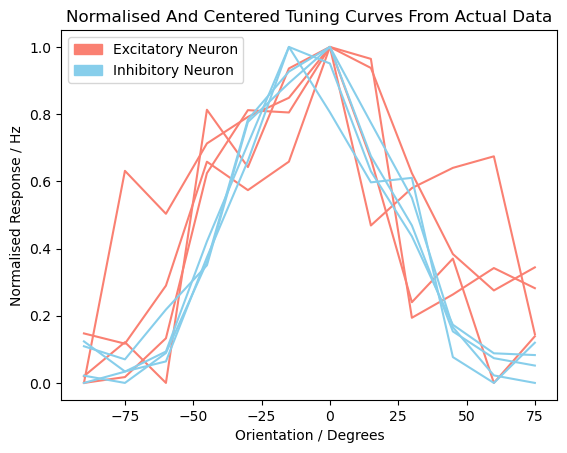

In [27]:
indexes = [10, 76]
colors = ["salmon", "skyblue", "seagreen", "khaki"]
x = unique_orientation - 90

for i, color in zip(indexes, colors):
    argmax = np.argmax(result_array[i][7])
    shift = 6 - np.argmax(result_array[i][7])
    for j in range(4,8):
        y = gaussian_filter1d(result_array[i][j], sigma=0.1)
        max_val = np.max(y)
        min_val = np.min(y)
        y_shifted = (np.roll(y, shift) - min_val) / (max_val - min_val)
        # y_shifted = np.roll(y, shift) / max_val
        plt.plot(x, y_shifted, color=color)

plt.title("Normalised And Centered Tuning Curves From Actual Data")
plt.xlabel("Orientation / Degrees")
plt.ylabel("Normalised Response / Hz")
red_patch = mpatches.Patch(color='salmon', label='Excitatory Neuron')
blue_patch = mpatches.Patch(color='skyblue', label='Inhibitory Neuron')
plt.legend(handles=[red_patch, blue_patch])
plt.show()

In [28]:
result_array.shape

(80, 8, 12)

In [29]:
result_array_con = result_array.transpose((0, 2, 1))
preds_array_con = preds_array.transpose((0, 2, 1))

In [30]:
preds_array_con.shape

(2000, 12, 8)

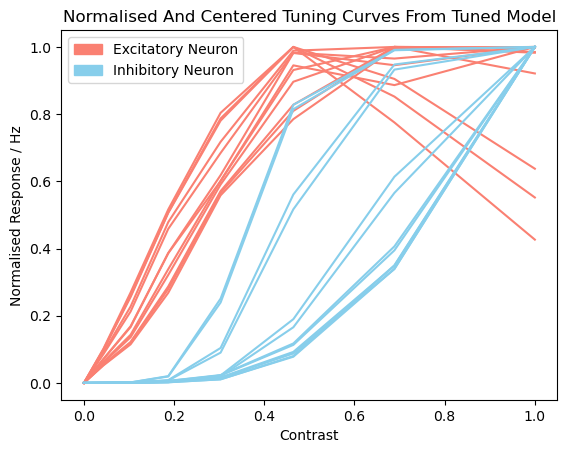

In [31]:
# indexes = [300, 488, 699, 966]
indexes = [550, 1951]
# indexes = [500, 600, 800, 856]
colors = ["salmon", "skyblue", "seagreen", "khaki", "mediumslateblue"]

for i, color in zip(indexes, colors):
    for j in range(12):
        y = preds_array_con[i][j]
        max_val = max(y)
        min_val = min(y)
        plt.plot(unique_contrast, (y - min_val) / (max_val - min_val), color=color)
        # plt.plot(unique_contrast, y)

plt.title("Normalised And Centered Tuning Curves From Tuned Model")
plt.xlabel("Contrast")
plt.ylabel("Normalised Response / Hz")
red_patch = mpatches.Patch(color='salmon', label='Excitatory Neuron')
blue_patch = mpatches.Patch(color='skyblue', label='Inhibitory Neuron')
plt.legend(handles=[red_patch, blue_patch])
plt.show()

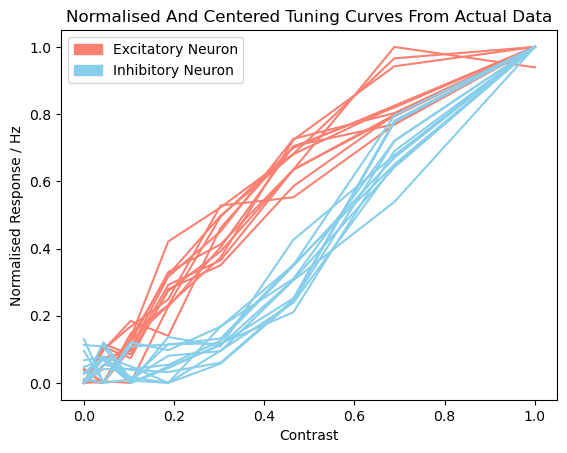

In [32]:
indexes = [10, 77]
colors = ["salmon", "skyblue", "seagreen", "khaki"]

for i, color in zip(indexes, colors):
    for j in range(12):
        y = result_array_con[i][j]
        max_val = max(y)
        min_val = min(y)
        plt.plot(unique_contrast, (y - min_val) / (max_val - min_val), color=color)

plt.title("Normalised And Centered Tuning Curves From Actual Data")
plt.xlabel("Contrast")
plt.ylabel("Normalised Response / Hz")
red_patch = mpatches.Patch(color='salmon', label='Excitatory Neuron')
blue_patch = mpatches.Patch(color='skyblue', label='Inhibitory Neuron')
plt.legend(handles=[red_patch, blue_patch])
plt.show()

In [33]:
one_res = []
for i in range(2000):
    one_res.append(preds_array[i][7][4])

Text(0, 0.5, 'Response / Hz')

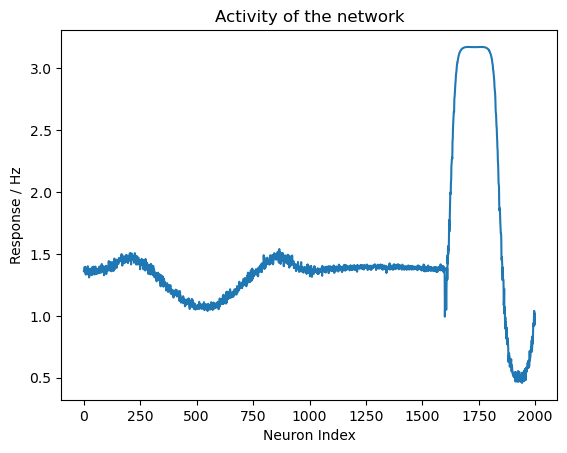

In [34]:
plt.plot(one_res)
plt.title("Activity of the network")
plt.xlabel("Neuron Index")
plt.ylabel("Response / Hz")